In [1]:
import pandas as pd

In [62]:
colors = {'dialogues' : 'red', 
          'dissertation' : 'orange', 
          'enquiry' : 'yellow', 
          'essay': 'forestgreen', 
          'history' : 'silver',
          'political discourses' : 'royalblue', 
          'treatise' : 'purple', 
          'other' : 'deeppink',
          'dissertation+essay' : 'orange',
          'enquiry+essay' : 'yellow',
          'essay+political discourses' : 'mediumturquoise'} 

In [2]:
df_short = pd.read_csv('extracted_bursts/extracted_transformer.csv').drop(columns=['Unnamed: 0'])

In [4]:
# create df chapter | paragraphs | genres

par_list = {ch:{} for ch in df_short['chapter'].to_list()}

for index, row in df_short.iterrows():
    ch = row['chapter']
    genre = row['genre']
    l = row['burst_len']
    start = row['start_in_chapter']
    bursts = []
    
    for i in range(start, start+l):
        if i in par_list[ch]:
            par_list[ch][i].append(genre)
        else:
            par_list[ch][i] = [genre, ]
            
ch_par_list = []            
for ch, value in par_list.items():
    for par, genres in value.items():
        ch_par_list.append([ch, par, '+'.join(genres)])
    
par_df = pd.DataFrame(ch_par_list, columns=['chapter', 'paragraph', 'genres'])   

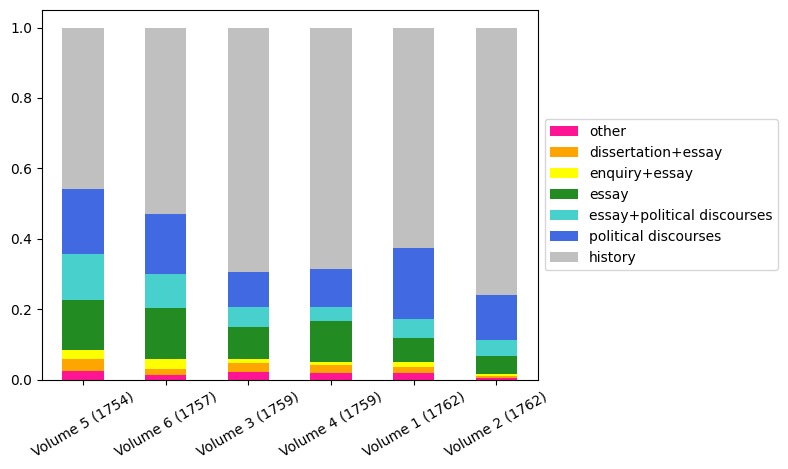

In [73]:
# add volumes
agg = par_df.join(df_short[['volume', 'chapter']].drop_duplicates().set_index('chapter'), on='chapter')

# count genres per volume
final = agg.groupby(['volume', 'genres'])['genres'].count().unstack()

final['years'] = [1762, 1762.5, 1759, 1759.5, 1754, 1757]
final['volume_len'] = [708, 792, 745, 552, 1209, 1040]
final = final.sort_values(by='years', ascending=True)

# count history paragraphs
col_list = list(final.columns[:17])
final['non_history'] = final[col_list].sum(axis=1)
final['history'] = final['volume_len'] - final['non_history']

col_list.append('history')

# join unfrequent genre types into one class
other = []
significant = []
significant.append('other')
for col in col_list:
    if final[col].sum() < 50:
        other.append(col)
    else:
        significant.append(col)

final['other'] = final[other].sum(axis=1)

# transform to percentage
for col in significant:
    final[col] = final[col] / final['volume_len']
    
final['non_history_per'] = 1 - final['history']


# plot genred per volume
ax = final[significant].plot.bar(stacked=True, legend=False, rot=30, color=colors, xlabel='')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

<Axes: >

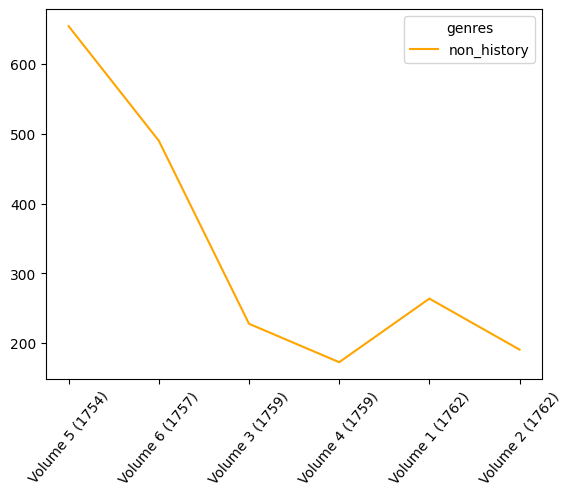

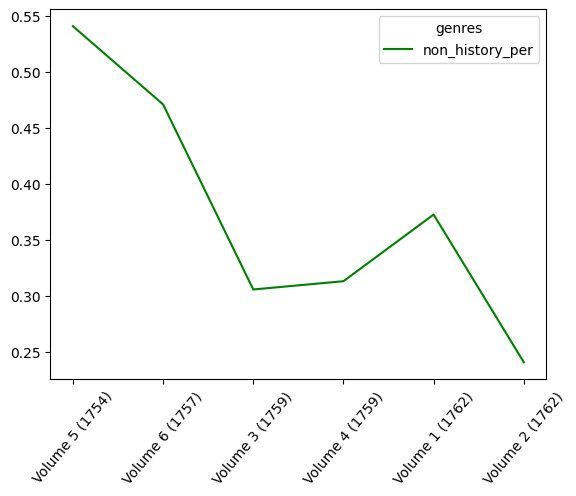

In [74]:
# number of extracted paragraphs
final[['non_history']].plot.line(rot=50, color='orange', xlabel='')
final[['non_history_per']].plot.line(rot=50, color='green', xlabel='')